In [1]:
import cv2
import numpy as np
from scipy.ndimage import sobel
from scipy.ndimage import gaussian_filter, uniform_filter
from scipy.ndimage import maximum_filter
from matplotlib import pyplot as plt

In [2]:
def compute_derivatives(image):

    img_gaussian = cv2.GaussianBlur(image, (3, 3), 0.5, borderType=cv2.BORDER_REFLECT)
    sobel_x = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=3, borderType=cv2.BORDER_REFLECT)
    sobel_y = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=3, borderType=cv2.BORDER_REFLECT)

    return sobel_x, sobel_y

def compute_orientation(sobel_x, sobel_y):
    # Compute orientation in degrees at each pixel
    orientation = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    return orientation

In [3]:
def compute_harris_matrix(image, window_size = 5):
    # Compute x and y derivatives
    sobel_x, sobel_y = compute_derivatives(image)
    height, width = image.shape

    # print("kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd")


    # Compute Gaussian filter for weights
    gaussian_mask = gaussian_filter(np.ones((5, 5)), sigma=0.5)

    kern = cv2.getGaussianKernel(5, 0.5)

    gaussian_mask = kern*kern.T

    Ix2 = np.square(sobel_x)
    Iy2 = np.square(sobel_y)
    Ixy = sobel_x * sobel_y 

    R_matrix = np.zeros((height,width))

    window = window_size//2

    for y in range(window, height - window):
        for x in range(window, width - window):

            wIx2 = np.sum((Ix2[y - window : y + window+1, x - window : x + window+1])*gaussian_mask)
            wIy2 = np.sum((Iy2[y - window : y + window+1, x - window : x + window+1])*gaussian_mask)
            wIxy = np.sum((Ixy[y - window : y + window+1, x - window : x + window+1])*gaussian_mask)


            M = np.array([[wIx2,wIxy],[wIxy,wIy2]])


            det = np.linalg.det(M)
            tr = np.matrix.trace(M)
            R = det - 0.05*(tr**2)
            R_matrix[y-2, x-2]=R

    return R_matrix

def find_maxima(img, R_matrix, threshold): 

    height = img.shape[0]   #.shape[0] outputs height 
    width = img.shape[1]    #.shape[1] outputs width .shape[2] outputs color channels of image

    # Normalize R_matrix
    R_matrix_normalized  = cv2.normalize(R_matrix, None, 0, 1, cv2.NORM_MINMAX)


    # Use maximum_filter to find local maxima
    thresholded_matrix_R = R_matrix_normalized  > threshold
    local_maxima = maximum_filter(thresholded_matrix_R, size=7) == thresholded_matrix_R
    
    dx, dy = compute_derivatives(img)
    orientations = compute_orientation(dx, dy)

    keypoints = []
    # Iterate over local maxima
    for y in range(2, height-2):
        for x in range(2, width-2):
            if local_maxima[y, x]:
                value = R_matrix_normalized [y, x]
                # Check if value exceeds threshold
                if value > threshold:
                    # Draw circle at local maximum
                    # cv2.circle(img, (x, y), 3, (0, 255, 0))
                    keypoints.append((x, y, orientations[y, x]))
            # print(orientations[y,x])

    # Convert OpenCV KeyPoint objects
    kp_orb = [cv2.KeyPoint(x, y, size=7, angle=orientation) for x, y, orientation in keypoints]
       
    return kp_orb


In [4]:
def HarrisPointsDetector(image, threshold= 0.83):
    if type(image) == str:
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # print("kajhkasjdhkasjdhaksjhdaskjdhaskjdhaskdjhaaksjdkasjdhaksjdhaskdjhaskdjh")

    # plt.imshow(image)
    # plt.show()

    R_matrix = compute_harris_matrix(image)
    # print(R_matrix)
    kps = find_maxima(image, R_matrix, threshold)
    return kps
    

In [5]:
import cv2
import os
import matplotlib.pyplot as plt


# Path to the folder containing images
folder_path = "./imgs"
results_folder = "./results"

# Create the results folder if it doesn't exist
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# List all files in the folder
image_files = os.listdir(folder_path)

# Initialize ORB detector with Harris corners
orb_harris = cv2.ORB_create()

# Initialize ORB detector with FAST corners
orb_fast = cv2.ORB_create(scoreType=cv2.ORB_FAST_SCORE)

counter = 0
threshes = [0.83, 0.62, 0.81, 0.99779, 0.87, 0.46, 0.83, 0.885, 0.83, 0.49, 0.828, 0.63]
multiples = [100, 100, 100, 100000, 100, 100, 100, 1000, 100, 100, 1000, 100]

lists = [[] for i in range(len(threshes))] 
for i in range(len(threshes)):
    num = threshes[i] * multiples[i]
    # print(num)
    lists[i].append(num-1)
    for j in range(9):
        lists[i].append(num+j)
    lists[i] = [round(x/multiples[i], 5) for x in lists[i]]

print(lists)

for filename in image_files:
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Filter image files
        # Read the image
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        print(os.path.join(folder_path, filename))

[[0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91], [0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7], [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89], [0.99778, 0.99779, 0.9978, 0.99781, 0.99782, 0.99783, 0.99784, 0.99785, 0.99786, 0.99787], [0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95], [0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54], [0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91], [0.884, 0.885, 0.886, 0.887, 0.888, 0.889, 0.89, 0.891, 0.892, 0.893], [0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91], [0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57], [0.827, 0.828, 0.829, 0.83, 0.831, 0.832, 0.833, 0.834, 0.835, 0.836], [0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71]]
./imgs\bernie180.jpg
./imgs\bernieBenefitBeautySalon.jpeg
./imgs\BernieFriends.png
./imgs\bernieMoreblurred.jpg
./imgs\bernieNoisy2.png
./imgs\berniePixelated2.png
./imgs\bernieSanders.jpg
./imgs\bernieShoolLunch.jpeg

[[0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91], [0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7], [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89], [0.99778, 0.99779, 0.9978, 0.99781, 0.99782, 0.99783, 0.99784, 0.99785, 0.99786, 0.99787], [0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95], [0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54], [0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91], [0.884, 0.885, 0.886, 0.887, 0.888, 0.889, 0.89, 0.891, 0.892, 0.893], [0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91], [0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57], [0.827, 0.828, 0.829, 0.83, 0.831, 0.832, 0.833, 0.834, 0.835, 0.836], [0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71]]
[5358266, 965, 213, 89, 49, 22, 11, 8, 5, 5]


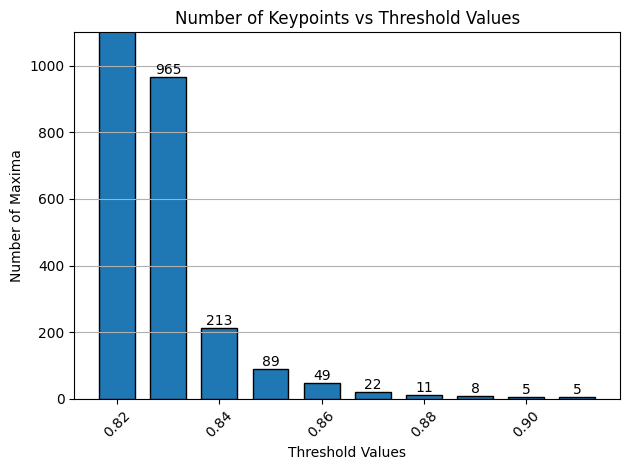

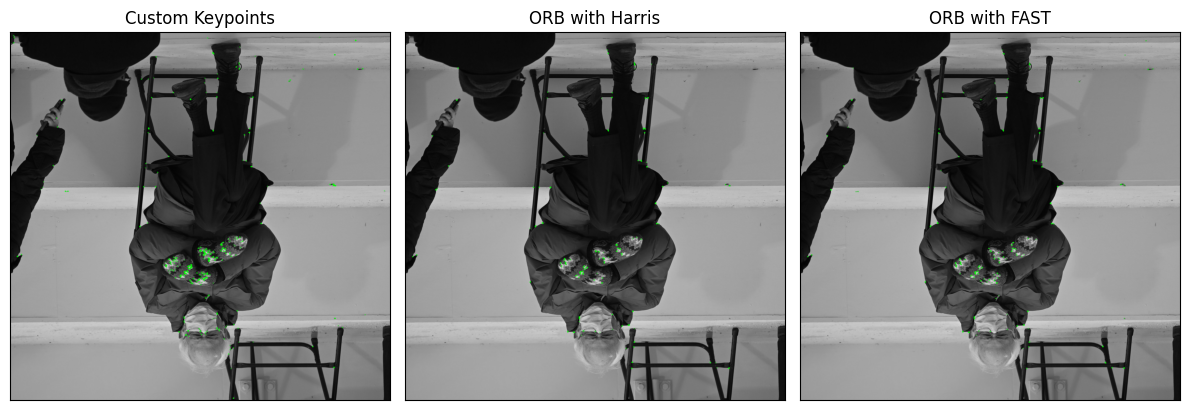

[1173, 684, 435, 281, 192, 132, 102, 77, 63, 49]


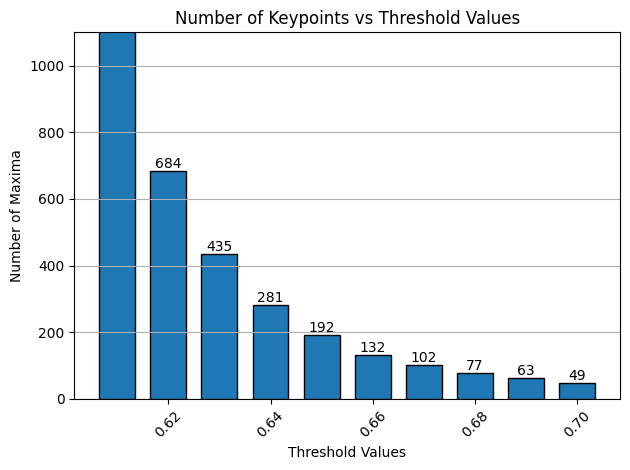

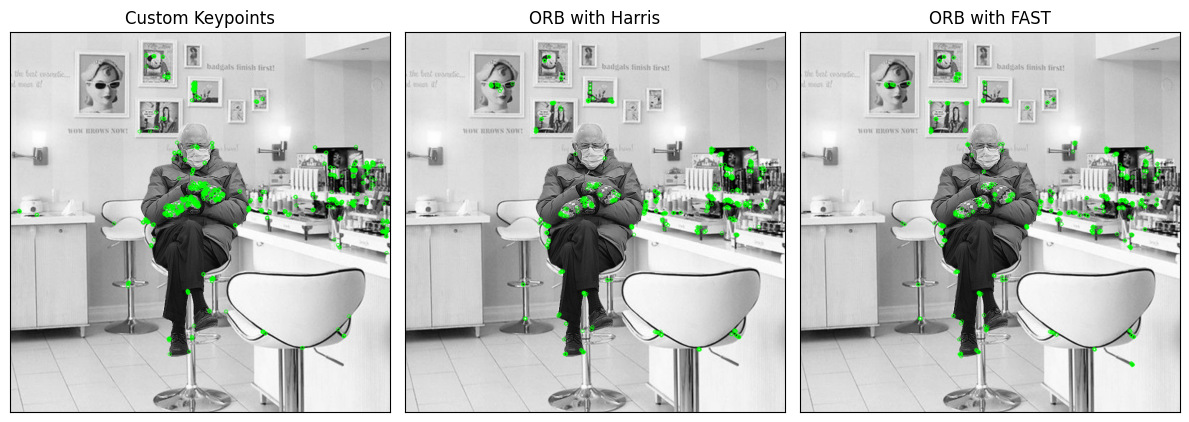

[1391, 569, 332, 242, 171, 125, 87, 59, 47, 33]


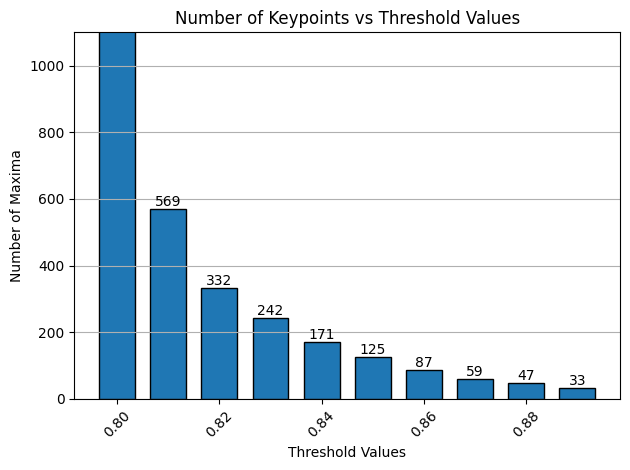

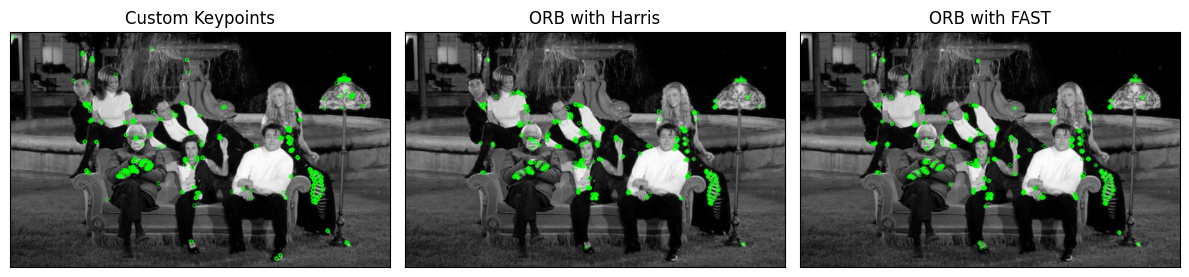

[943, 834, 761, 688, 628, 578, 533, 487, 450, 429]


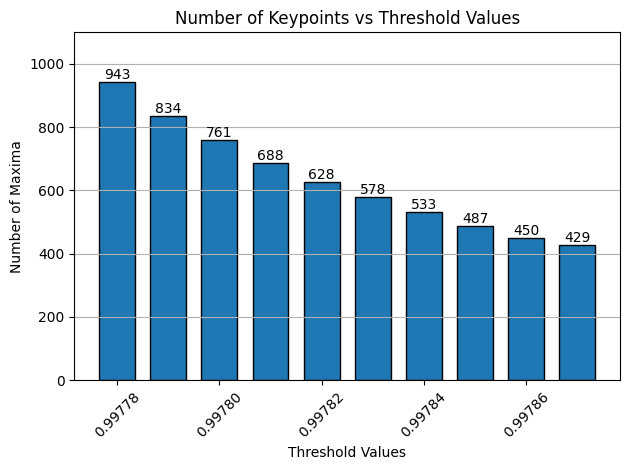

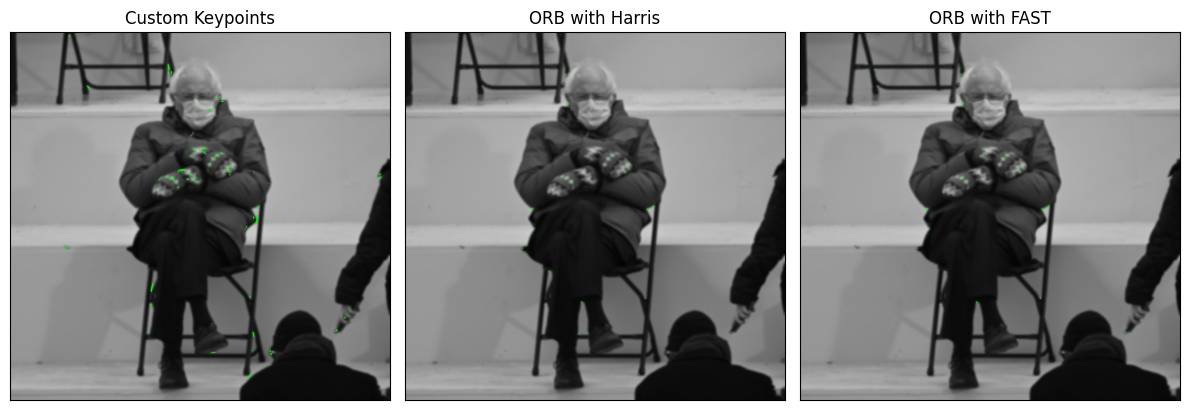

[1591, 614, 280, 132, 78, 41, 30, 20, 9, 8]


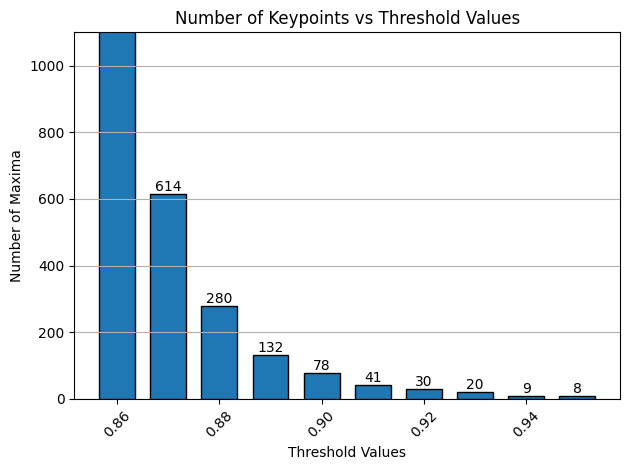

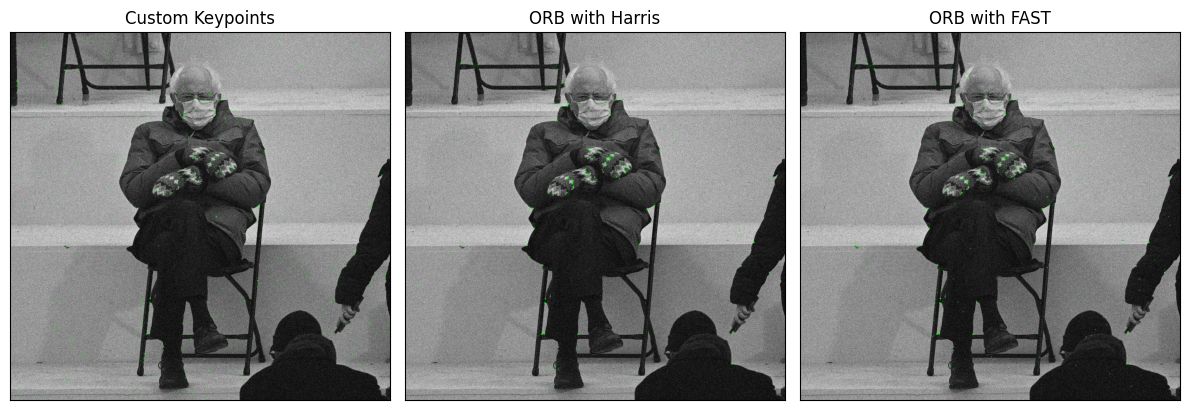

[1177, 737, 510, 452, 428, 400, 371, 315, 275, 198]


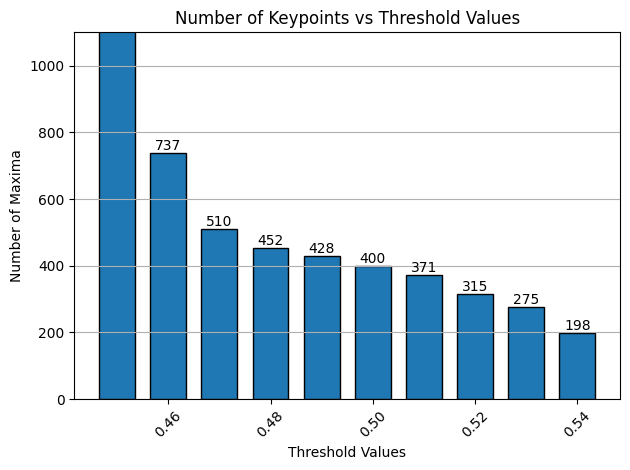

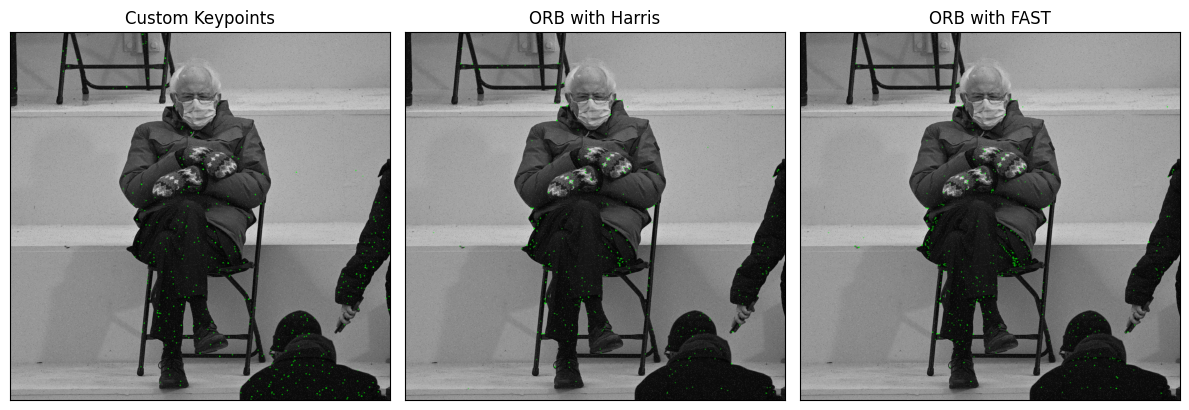

[5358239, 965, 213, 89, 49, 22, 11, 8, 5, 5]


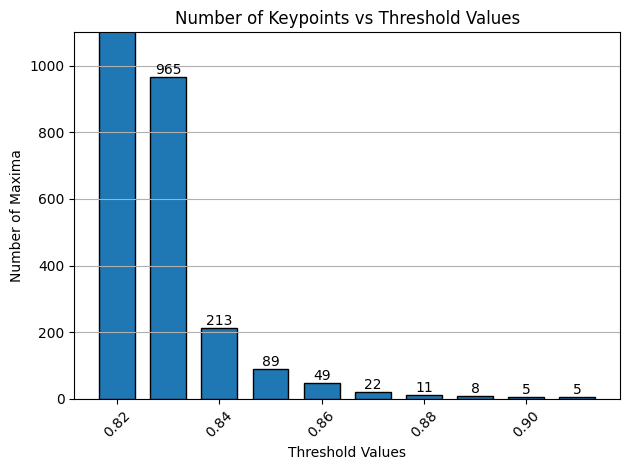

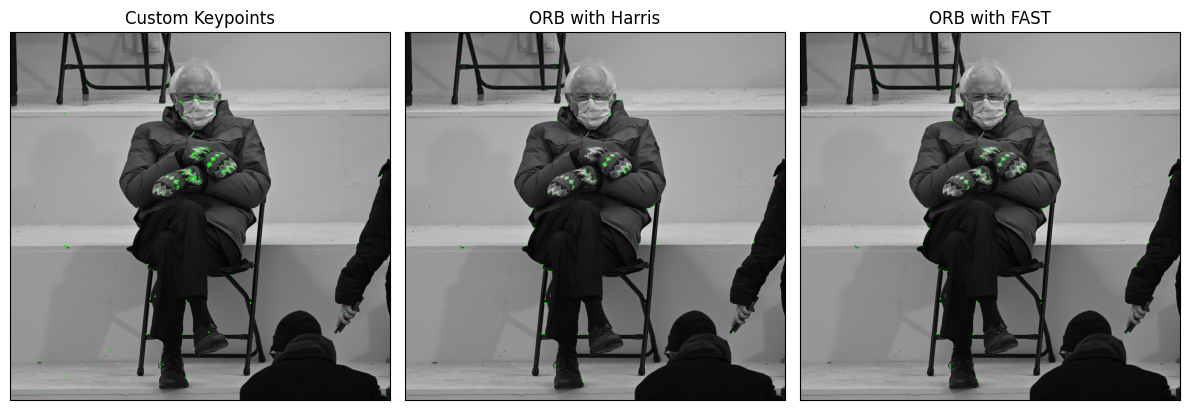

[970, 827, 727, 640, 574, 505, 459, 412, 368, 333]


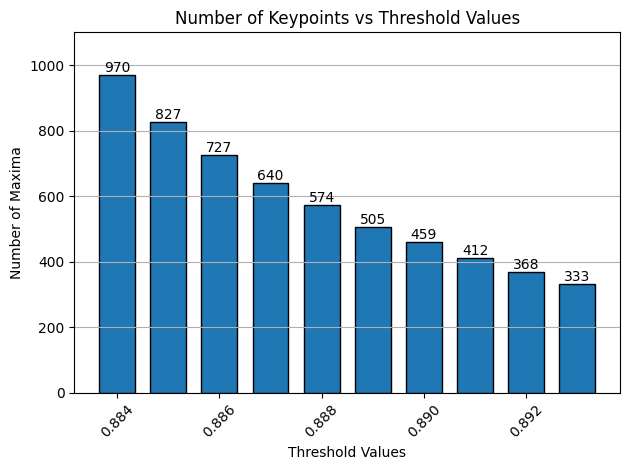

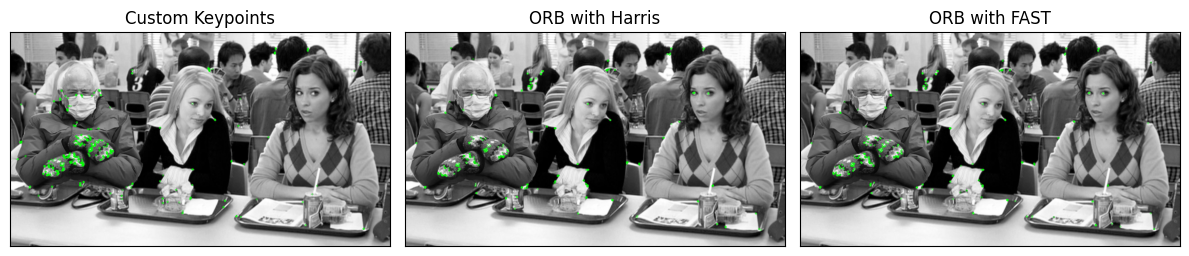

[5353313, 790, 196, 82, 43, 17, 10, 8, 5, 5]


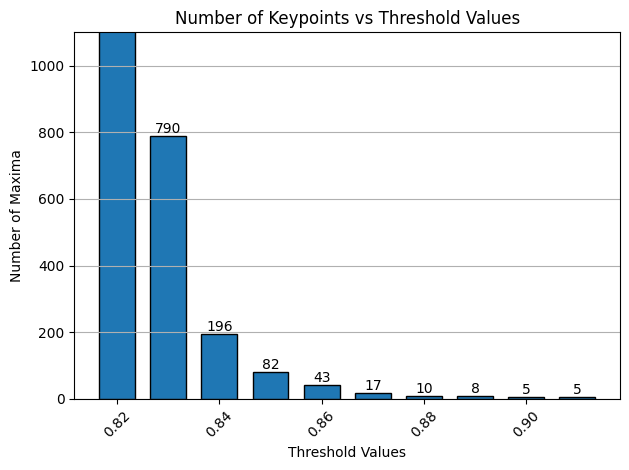

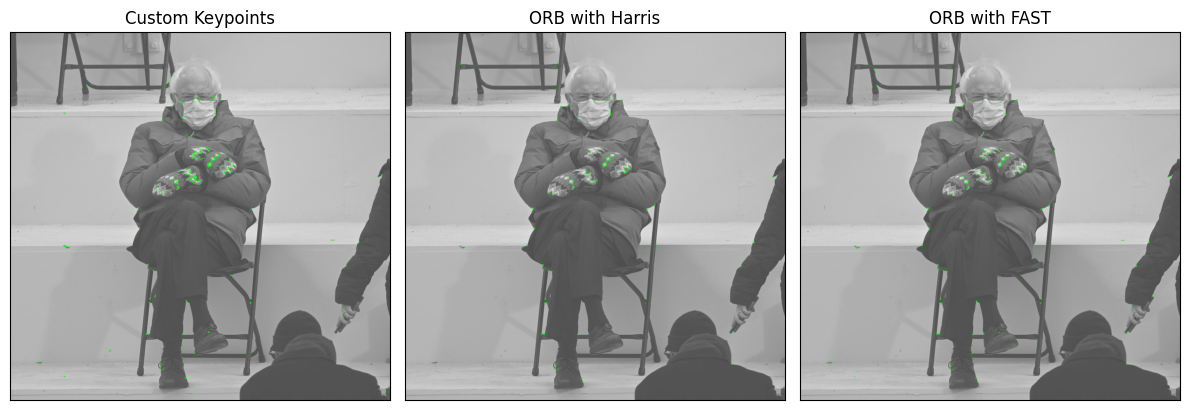

[1022, 895, 789, 705, 639, 578, 520, 468, 428, 389]


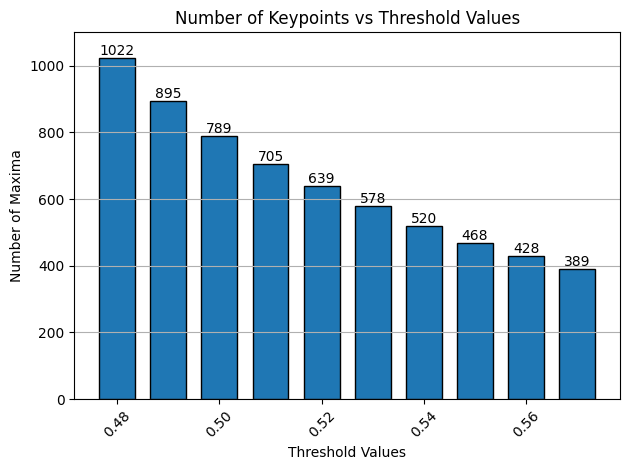

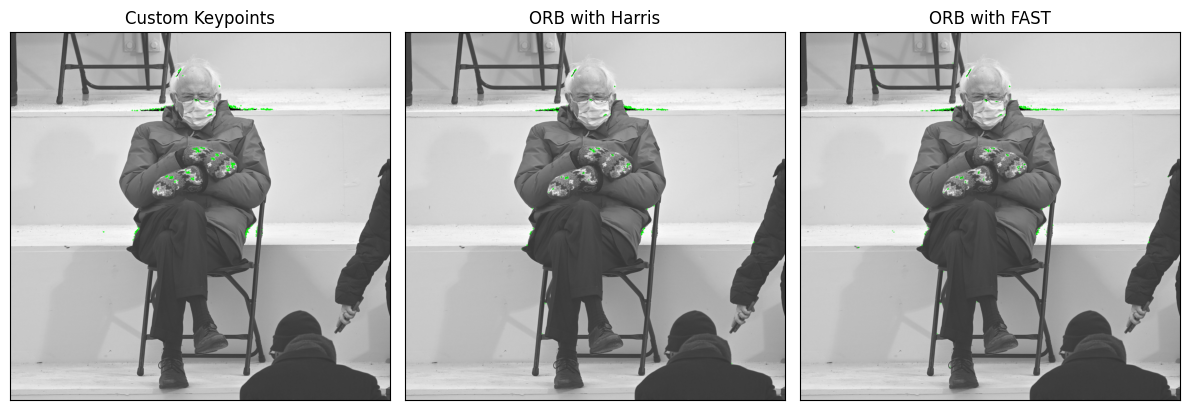

[1060, 840, 702, 599, 504, 425, 366, 317, 275, 246]


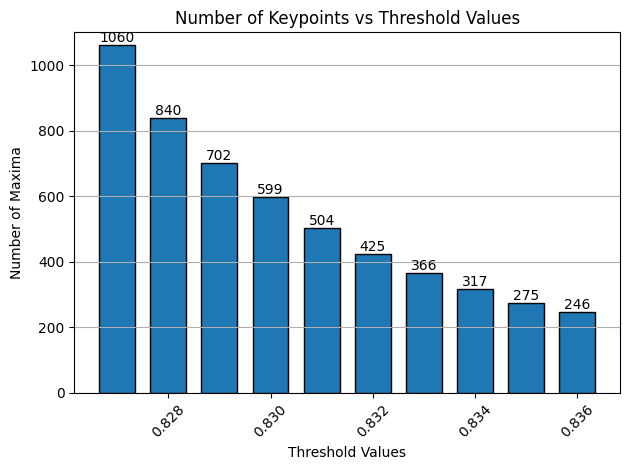

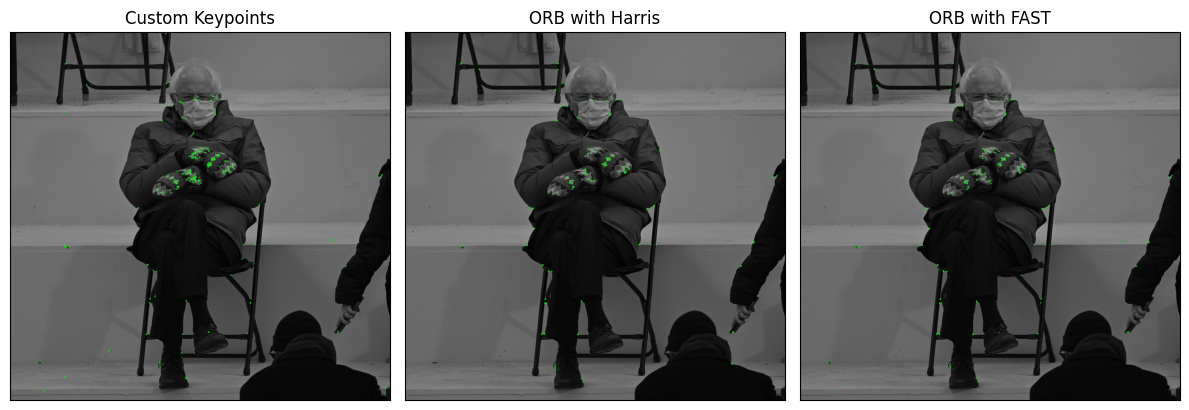

[1040, 926, 826, 734, 645, 578, 514, 461, 420, 381]


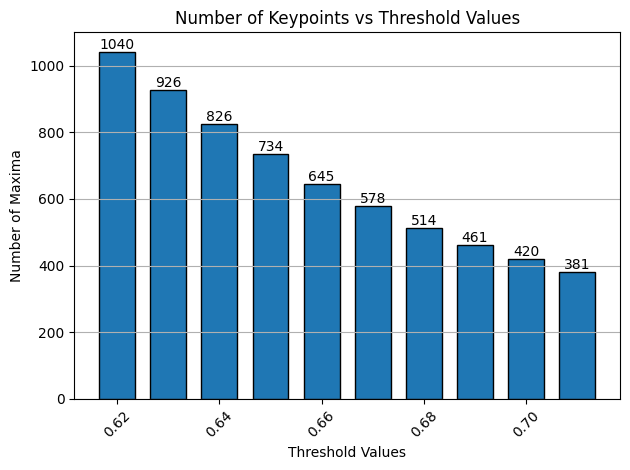

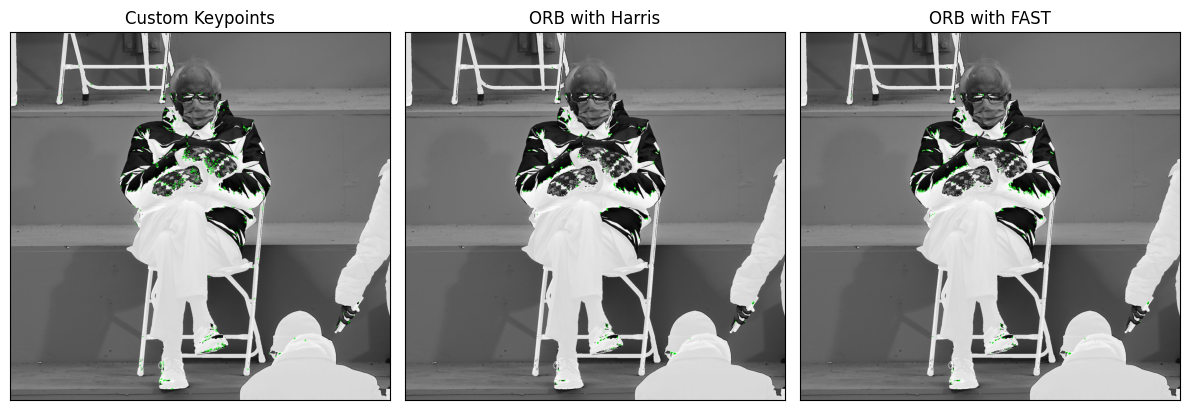

In [50]:
import cv2
import os
import matplotlib.pyplot as plt


# Path to the folder containing images
folder_path = "./imgs"
results_folder = "./results"

# Create the results folder if it doesn't exist
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# List all files in the folder
image_files = os.listdir(folder_path)

# Initialize ORB detector with Harris corners
orb_harris = cv2.ORB_create()

# Initialize ORB detector with FAST corners
orb_fast = cv2.ORB_create(scoreType=cv2.ORB_FAST_SCORE)

counter = 0
threshes = [0.83, 0.62, 0.81, 0.99779, 0.87, 0.46, 0.83, 0.885, 0.83, 0.49, 0.828, 0.63]
multiples = [100, 100, 100, 100000, 100, 100, 100, 1000, 100, 100, 1000, 100]

lists = [[] for i in range(len(threshes))] 
for i in range(len(threshes)):
    num = threshes[i] * multiples[i]
    # print(num)
    lists[i].append(num-1)
    for j in range(9):
        lists[i].append(num+j)
    lists[i] = [round(x/multiples[i], 5) for x in lists[i]]

print(lists)

for filename in image_files:
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Filter image files
        # Read the image
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)

        # print("hi")
        R_matrix = compute_harris_matrix(img)
        kp_custom = find_maxima(img, R_matrix, threshes[counter])
        


        # Detect Harris corners (replace this with your HarrisPointsDetector function)
        # kp_custom = HarrisPointsDetector(img)

        # print(len(kp_custom))

        # Detect keypoints with ORB
        kp_harris = orb_harris.detect(img, None)
        kp_fast = orb_fast.detect(img, None)

        # Compute descriptors with ORB
        kp_harris, des_harris = orb_harris.compute(img, kp_harris)
        kp_fast, des_fast = orb_fast.compute(img, kp_fast)

        # Draw keypoints on the images
        img_custom = cv2.drawKeypoints(img, kp_custom, None, color=(0, 255, 0), flags=0)
        img_harris = cv2.drawKeypoints(img, kp_harris, None, color=(0, 255, 0), flags=0)
        img_fast = cv2.drawKeypoints(img, kp_fast, None, color=(0, 255, 0), flags=0)

        
        # counter = 0
        # print(os.path.join(folder_path, filename), threshes[counter], len(find_maxima(img, R_matrix, threshes[counter])))

        

        thr = lists[counter]
        counts = []
        for j in thr:
            counts.append(len(find_maxima(img, R_matrix, j)))
            
        print(counts)

        # Generate floating-point values
        # values = [j / 100 for j in range(30, 100)]
        # Plot
        
        plt.bar(thr, counts, width=(0.7/multiples[counter]), align='center', edgecolor='black')  
        plt.xlabel('Threshold Values')
        plt.ylabel('Number of Maxima')
        plt.title('Number of Keypoints vs Threshold Values')
        plt.grid(axis='y')  

        # Add text annotations above each bar
        for i in range(len(counts)):
            if counts[i] < 1100:
                plt.text(thr[i], counts[i], str(counts[i]), ha='center', va='bottom')
        plt.ylim(top=1100)
        # plt.yticks(range(0, 801, 50))
        plt.xticks(rotation=45)  
        

        # Adjust spacing between bars
        plt.subplots_adjust(left=0.05, right=1-0.05)
        plt.tight_layout()  
        plt.savefig(os.path.join(results_folder, filename.split('.')[0] + '_plot.png'))

        plt.show()

        # Save the images
        # cv2.imwrite(os.path.join(results_folder, filename.split('.')[0] + '_custom.jpg'), img_custom)
        # cv2.imwrite(os.path.join(results_folder, filename.split('.')[0] + '_harris.jpg'), img_harris)
        # cv2.imwrite(os.path.join(results_folder, filename.split('.')[0] + '_fast.jpg'), img_fast)

        # Display the images side by side
        plt.figure(figsize=(12, 4.5))

        plt.subplot(1, 3, 1)
        plt.imshow(img_custom, cmap='gray')
        plt.title('Custom Keypoints')
        plt.xticks([]), plt.yticks([])  # Remove ticks

        plt.subplot(1, 3, 2)
        plt.imshow(img_harris, cmap='gray')
        plt.title('ORB with Harris')
        plt.xticks([]), plt.yticks([])  # Remove ticks

        plt.subplot(1, 3, 3)
        plt.imshow(img_fast, cmap='gray')
        plt.title('ORB with FAST')
        plt.xticks([]), plt.yticks([])  # Remove ticks
        plt.tight_layout()

        # Save the figure
        plt.savefig(os.path.join(results_folder, filename.split('.')[0] + '_result.png'))

        plt.show()


        counter += 1


In [40]:
img = cv2.imread('bernieMoreblurred.jpg', cv2.IMREAD_GRAYSCALE)

R_matrix = compute_harris_matrix(img)

plots = [0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91]

kp = find_maxima(img, R_matrix, 0.99779)
print(len(kp))


# # Initialize ORB detector
# orb = cv2.ORB_create()

# # Compute descriptors for keypoints
# keypoints, descriptors = orb.compute(img, kp)

# # Draw keypoints on the image
# img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, color=(0,255,0), flags=0)

# plt.figure(figsize=(20, 10))
# plt.imshow(img_with_keypoints)
# plt.axis('off')
# plt.show()

834


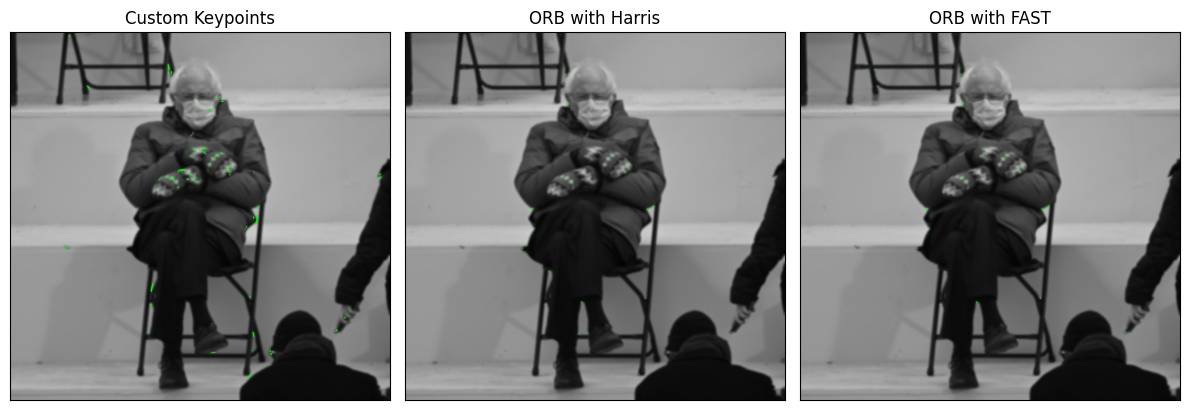

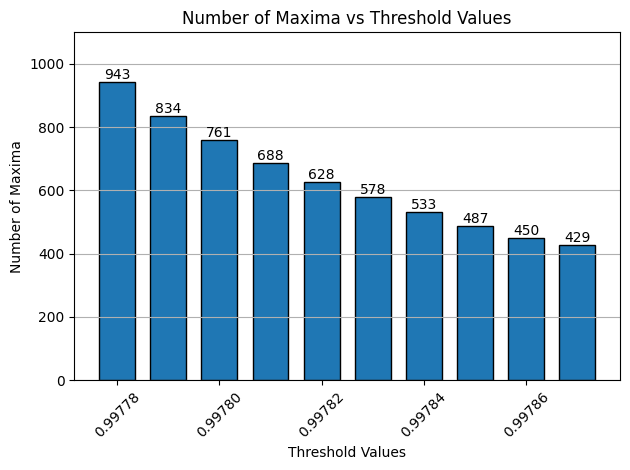

In [48]:
# Initialize ORB detector with Harris corners
orb_harris = cv2.ORB_create()

# Initialize ORB detector with FAST corners
orb_fast = cv2.ORB_create(scoreType=cv2.ORB_FAST_SCORE)

# Draw keypoints on the images
img_custom = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)
img_harris = cv2.drawKeypoints(img, kp_harris, None, color=(0, 255, 0), flags=0)
img_fast = cv2.drawKeypoints(img, kp_fast, None, color=(0, 255, 0), flags=0)

plt.figure(figsize=(12, 4.5))

plt.subplot(1, 3, 1)
plt.imshow(img_custom, cmap='gray')
plt.title('Custom Keypoints')
plt.xticks([]), plt.yticks([])  # Remove ticks

plt.subplot(1, 3, 2)
plt.imshow(img_harris, cmap='gray')
plt.title('ORB with Harris')
plt.xticks([]), plt.yticks([])  # Remove ticks

plt.subplot(1, 3, 3)
plt.imshow(img_fast, cmap='gray')
plt.title('ORB with FAST')
plt.xticks([]), plt.yticks([])  # Remove ticks

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(results_folder, filename.split('.')[0] + '_result.png'))


plt.show()

plt.bar(thr, counts, width=0.000007, align='center', edgecolor='black')  
plt.xlabel('Threshold Values')
plt.ylabel('Number of Maxima')
plt.title('Number of Maxima vs Threshold Values')
plt.grid(axis='y')  

# Add text annotations above each bar
for i in range(len(counts)):
    if counts[i] < 1000:
        plt.text(thr[i], counts[i], str(counts[i]), ha='center', va='bottom')
plt.ylim(top=1100)
# plt.yticks(range(0, 801, 50))
plt.xticks(rotation=45)  


# Adjust spacing between bars
plt.subplots_adjust(left=0.05, right=1-0.05)
plt.tight_layout()  
plt.savefig(os.path.join(results_folder, filename.split('.')[0] + '_plot.png'))

plt.show()


840


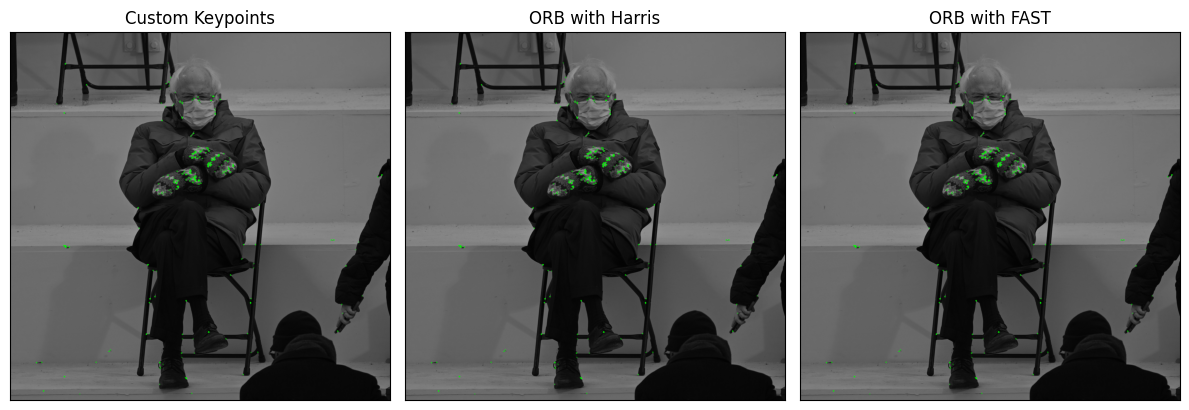

In [ ]:
# kp = find_maxima(img, R_matrix, 0.828)
# print(len(kp))
# orb = cv2.ORB_create()



# Compute descriptors for keypoints
keypoints, descriptors = orb.compute(img, kp)

# Draw keypoints on the image
img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, color=(0,255,0), flags=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img_with_keypoints, cmap='gray')
plt.title('Custom Keypoints')
plt.xticks([]), plt.yticks([])  # Remove ticks

plt.subplot(1, 3, 2)
plt.imshow(img_with_keypoints, cmap='gray')
plt.title('ORB with Harris')
plt.xticks([]), plt.yticks([])  # Remove ticks

plt.subplot(1, 3, 3)
plt.imshow(img_with_keypoints, cmap='gray')
plt.title('ORB with FAST')
plt.xticks([]), plt.yticks([])  # Remove ticks
plt.tight_layout()
plt.show()



In [ ]:
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 5425011], [0.31, 5425003], [0.32, 5424995], [0.33, 5424977], [0.34, 5424963], [0.35, 5424947], [0.36, 5424931], [0.37, 5424921], [0.38, 5424906], [0.39, 5424890], [0.4, 5424866], [0.41, 5424844], [0.42, 5424816], [0.43, 5424792], [0.44, 5424766], [0.45, 5424737], [0.46, 5424694], [0.47, 5424650], [0.48, 5424592], [0.49, 5424549], [0.5, 5424483], [0.51, 5424414], [0.52, 5424344], [0.53, 5424286], [0.54, 5424213], [0.55, 5424144], [0.56, 5424059], [0.57, 5423963], [0.58, 5423862], [0.59, 5423762], [0.6, 5423643], [0.61, 5423510], [0.62, 5423368], [0.63, 5423196], [0.64, 5422943], [0.65, 5422709], [0.66, 5422423], [0.67, 5422072], [0.68, 5421665], [0.69, 5421165], [0.7, 5420624], [0.71, 5419945], [0.72, 5419087], [0.73, 5418046], [0.74, 5416899], [0.75, 5415452], [0.76, 5413621], [0.77, 5411296], [0.78, 5408206], [0.79, 5403967], [0.8, 5397733], [0.81, 5385744], [0.82, 5358266], [0.83, 965], [0.84, 213], [0.85, 89], [0.86, 49], [0.87, 22], [0.88, 11], [0.89, 8], [0.9, 5], [0.91, 5], [0.92, 3], [0.93, 1], [0.94, 1], [0.95, 1], [0.96, 1], [0.97, 1], [0.98, 1], [0.99, 1]]
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 512331], [0.31, 512284], [0.32, 512230], [0.33, 512171], [0.34, 512084], [0.35, 512009], [0.36, 511920], [0.37, 511834], [0.38, 511750], [0.39, 511648], [0.4, 511517], [0.41, 511394], [0.42, 511254], [0.43, 511104], [0.44, 510950], [0.45, 510758], [0.46, 510533], [0.47, 510267], [0.48, 509943], [0.49, 509606], [0.5, 509217], [0.51, 508735], [0.52, 508168], [0.53, 507459], [0.54, 506553], [0.55, 505390], [0.56, 503746], [0.57, 501135], [0.58, 496472], [0.59, 480476], [0.6, 2611], [0.61, 1173], [0.62, 684], [0.63, 435], [0.64, 281], [0.65, 192], [0.66, 132], [0.67, 102], [0.68, 77], [0.69, 63], [0.7, 49], [0.71, 41], [0.72, 35], [0.73, 26], [0.74, 20], [0.75, 19], [0.76, 13], [0.77, 9], [0.78, 7], [0.79, 5], [0.8, 5], [0.81, 4], [0.82, 4], [0.83, 4], [0.84, 3], [0.85, 3], [0.86, 3], [0.87, 3], [0.88, 2], [0.89, 2], [0.9, 2], [0.91, 1], [0.92, 1], [0.93, 1], [0.94, 1], [0.95, 1], [0.96, 1], [0.97, 1], [0.98, 1], [0.99, 1]]
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 315701], [0.31, 315695], [0.32, 315682], [0.33, 315673], [0.34, 315658], [0.35, 315642], [0.36, 315630], [0.37, 315613], [0.38, 315592], [0.39, 315583], [0.4, 315568], [0.41, 315553], [0.42, 315535], [0.43, 315519], [0.44, 315503], [0.45, 315482], [0.46, 315460], [0.47, 315435], [0.48, 315416], [0.49, 315388], [0.5, 315355], [0.51, 315323], [0.52, 315286], [0.53, 315242], [0.54, 315206], [0.55, 315172], [0.56, 315123], [0.57, 315076], [0.58, 315027], [0.59, 314971], [0.6, 314928], [0.61, 314876], [0.62, 314828], [0.63, 314750], [0.64, 314686], [0.65, 314590], [0.66, 314495], [0.67, 314391], [0.68, 314263], [0.69, 314132], [0.7, 313956], [0.71, 313737], [0.72, 313470], [0.73, 313139], [0.74, 312706], [0.75, 312124], [0.76, 311394], [0.77, 310208], [0.78, 308159], [0.79, 302075], [0.8, 1391], [0.81, 569], [0.82, 332], [0.83, 242], [0.84, 171], [0.85, 125], [0.86, 87], [0.87, 59], [0.88, 47], [0.89, 33], [0.9, 25], [0.91, 18], [0.92, 11], [0.93, 11], [0.94, 8], [0.95, 7], [0.96, 5], [0.97, 3], [0.98, 3], [0.99, 2]]
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 5424436], [0.31, 5424387], [0.32, 5424321], [0.33, 5424260], [0.34, 5424194], [0.35, 5424147], [0.36, 5424089], [0.37, 5424025], [0.38, 5423950], [0.39, 5423880], [0.4, 5423807], [0.41, 5423719], [0.42, 5423638], [0.43, 5423577], [0.44, 5423475], [0.45, 5423360], [0.46, 5423260], [0.47, 5423114], [0.48, 5422930], [0.49, 5422745], [0.5, 5422623], [0.51, 5422502], [0.52, 5422374], [0.53, 5422228], [0.54, 5422065], [0.55, 5421877], [0.56, 5421671], [0.57, 5421442], [0.58, 5421242], [0.59, 5421068], [0.6, 5420887], [0.61, 5420690], [0.62, 5420482], [0.63, 5420271], [0.64, 5419971], [0.65, 5419692], [0.66, 5419365], [0.67, 5419010], [0.68, 5418664], [0.69, 5418271], [0.7, 5417789], [0.71, 5417090], [0.72, 5416525], [0.73, 5415824], [0.74, 5415209], [0.75, 5414341], [0.76, 5413366], [0.77, 5412142], [0.78, 5411034], [0.79, 5409844], [0.8, 5408372], [0.81, 5406620], [0.82, 5404454], [0.83, 5402360], [0.84, 5399834], [0.85, 5396553], [0.86, 5392266], [0.87, 5388265], [0.88, 5383519], [0.89, 5376565], [0.9, 5369816], [0.91, 5360777], [0.92, 5348074], [0.93, 5336117], [0.94, 5318802], [0.95, 5301699], [0.96, 5278550], [0.97, 5247345], [0.98, 5204889], [0.99, 5128168]]
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 5425156], [0.31, 5425154], [0.32, 5425152], [0.33, 5425152], [0.34, 5425152], [0.35, 5425151], [0.36, 5425149], [0.37, 5425148], [0.38, 5425146], [0.39, 5425143], [0.4, 5425142], [0.41, 5425140], [0.42, 5425136], [0.43, 5425132], [0.44, 5425121], [0.45, 5425117], [0.46, 5425109], [0.47, 5425102], [0.48, 5425099], [0.49, 5425089], [0.5, 5425082], [0.51, 5425074], [0.52, 5425063], [0.53, 5425050], [0.54, 5425039], [0.55, 5425025], [0.56, 5425005], [0.57, 5424979], [0.58, 5424962], [0.59, 5424915], [0.6, 5424886], [0.61, 5424863], [0.62, 5424810], [0.63, 5424763], [0.64, 5424711], [0.65, 5424639], [0.66, 5424557], [0.67, 5424453], [0.68, 5424340], [0.69, 5424202], [0.7, 5424013], [0.71, 5423803], [0.72, 5423535], [0.73, 5423215], [0.74, 5422765], [0.75, 5422181], [0.76, 5421389], [0.77, 5420305], [0.78, 5418716], [0.79, 5416284], [0.8, 5411737], [0.81, 5399446], [0.82, 5249476], [0.83, 136045], [0.84, 19386], [0.85, 4778], [0.86, 1591], [0.87, 614], [0.88, 280], [0.89, 132], [0.9, 78], [0.91, 41], [0.92, 30], [0.93, 20], [0.94, 9], [0.95, 8], [0.96, 4], [0.97, 2], [0.98, 2], [0.99, 1]]
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 5423108], [0.31, 5422294], [0.32, 5421030], [0.33, 5418874], [0.34, 5414857], [0.35, 5407186], [0.36, 5377564], [0.37, 120862], [0.38, 11974], [0.39, 4715], [0.4, 2941], [0.41, 2228], [0.42, 1920], [0.43, 1693], [0.44, 1464], [0.45, 1177], [0.46, 737], [0.47, 510], [0.48, 452], [0.49, 428], [0.5, 400], [0.51, 371], [0.52, 315], [0.53, 275], [0.54, 198], [0.55, 127], [0.56, 57], [0.57, 39], [0.58, 33], [0.59, 31], [0.6, 29], [0.61, 29], [0.62, 28], [0.63, 27], [0.64, 26], [0.65, 24], [0.66, 23], [0.67, 23], [0.68, 22], [0.69, 21], [0.7, 20], [0.71, 20], [0.72, 18], [0.73, 17], [0.74, 15], [0.75, 15], [0.76, 13], [0.77, 12], [0.78, 12], [0.79, 11], [0.8, 10], [0.81, 9], [0.82, 9], [0.83, 9], [0.84, 9], [0.85, 9], [0.86, 8], [0.87, 8], [0.88, 7], [0.89, 6], [0.9, 6], [0.91, 6], [0.92, 6], [0.93, 6], [0.94, 4], [0.95, 4], [0.96, 4], [0.97, 3], [0.98, 2], [0.99, 1]]
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 5425011], [0.31, 5425003], [0.32, 5424995], [0.33, 5424977], [0.34, 5424963], [0.35, 5424947], [0.36, 5424931], [0.37, 5424921], [0.38, 5424906], [0.39, 5424890], [0.4, 5424866], [0.41, 5424844], [0.42, 5424816], [0.43, 5424792], [0.44, 5424766], [0.45, 5424737], [0.46, 5424694], [0.47, 5424650], [0.48, 5424592], [0.49, 5424549], [0.5, 5424483], [0.51, 5424414], [0.52, 5424344], [0.53, 5424286], [0.54, 5424213], [0.55, 5424144], [0.56, 5424059], [0.57, 5423963], [0.58, 5423862], [0.59, 5423762], [0.6, 5423643], [0.61, 5423510], [0.62, 5423368], [0.63, 5423196], [0.64, 5422943], [0.65, 5422709], [0.66, 5422423], [0.67, 5422072], [0.68, 5421664], [0.69, 5421162], [0.7, 5420619], [0.71, 5419939], [0.72, 5419078], [0.73, 5418035], [0.74, 5416888], [0.75, 5415438], [0.76, 5413606], [0.77, 5411279], [0.78, 5408186], [0.79, 5403941], [0.8, 5397710], [0.81, 5385715], [0.82, 5358239], [0.83, 965], [0.84, 213], [0.85, 89], [0.86, 49], [0.87, 22], [0.88, 11], [0.89, 8], [0.9, 5], [0.91, 5], [0.92, 3], [0.93, 1], [0.94, 1], [0.95, 1], [0.96, 1], [0.97, 1], [0.98, 1], [0.99, 1]]
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 1431575], [0.31, 1431571], [0.32, 1431567], [0.33, 1431560], [0.34, 1431556], [0.35, 1431551], [0.36, 1431548], [0.37, 1431540], [0.38, 1431530], [0.39, 1431521], [0.4, 1431514], [0.41, 1431502], [0.42, 1431492], [0.43, 1431480], [0.44, 1431459], [0.45, 1431443], [0.46, 1431421], [0.47, 1431389], [0.48, 1431364], [0.49, 1431336], [0.5, 1431296], [0.51, 1431278], [0.52, 1431233], [0.53, 1431195], [0.54, 1431151], [0.55, 1431094], [0.56, 1431047], [0.57, 1430988], [0.58, 1430913], [0.59, 1430836], [0.6, 1430742], [0.61, 1430642], [0.62, 1430528], [0.63, 1430374], [0.64, 1430254], [0.65, 1430127], [0.66, 1429971], [0.67, 1429820], [0.68, 1429654], [0.69, 1429464], [0.7, 1429240], [0.71, 1428972], [0.72, 1428667], [0.73, 1428349], [0.74, 1428012], [0.75, 1427576], [0.76, 1427096], [0.77, 1426441], [0.78, 1425648], [0.79, 1424546], [0.8, 1423202], [0.81, 1421421], [0.82, 1419006], [0.83, 1415904], [0.84, 1411595], [0.85, 1405311], [0.86, 1394061], [0.87, 1364235], [0.88, 2201], [0.89, 459], [0.9, 187], [0.91, 98], [0.92, 57], [0.93, 38], [0.94, 18], [0.95, 10], [0.96, 8], [0.97, 6], [0.98, 3], [0.99, 3]]
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 5425012], [0.31, 5425006], [0.32, 5424999], [0.33, 5424983], [0.34, 5424966], [0.35, 5424952], [0.36, 5424938], [0.37, 5424922], [0.38, 5424907], [0.39, 5424887], [0.4, 5424867], [0.41, 5424842], [0.42, 5424819], [0.43, 5424793], [0.44, 5424765], [0.45, 5424726], [0.46, 5424687], [0.47, 5424642], [0.48, 5424590], [0.49, 5424528], [0.5, 5424465], [0.51, 5424402], [0.52, 5424331], [0.53, 5424268], [0.54, 5424202], [0.55, 5424124], [0.56, 5424044], [0.57, 5423942], [0.58, 5423840], [0.59, 5423739], [0.6, 5423616], [0.61, 5423482], [0.62, 5423323], [0.63, 5423120], [0.64, 5422879], [0.65, 5422656], [0.66, 5422339], [0.67, 5421985], [0.68, 5421570], [0.69, 5421078], [0.7, 5420534], [0.71, 5419836], [0.72, 5418909], [0.73, 5417875], [0.74, 5416692], [0.75, 5415203], [0.76, 5413297], [0.77, 5410862], [0.78, 5407721], [0.79, 5403293], [0.8, 5396775], [0.81, 5383966], [0.82, 5353313], [0.83, 790], [0.84, 196], [0.85, 82], [0.86, 43], [0.87, 17], [0.88, 10], [0.89, 8], [0.9, 5], [0.91, 5], [0.92, 3], [0.93, 2], [0.94, 1], [0.95, 1], [0.96, 1], [0.97, 1], [0.98, 1], [0.99, 1]]
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 5423430], [0.31, 5423296], [0.32, 5423145], [0.33, 5422950], [0.34, 5422784], [0.35, 5422578], [0.36, 5422307], [0.37, 5421777], [0.38, 5420735], [0.39, 5416895], [0.4, 5388216], [0.41, 4027], [0.42, 2912], [0.43, 2365], [0.44, 1951], [0.45, 1623], [0.46, 1379], [0.47, 1175], [0.48, 1022], [0.49, 895], [0.5, 789], [0.51, 705], [0.52, 639], [0.53, 578], [0.54, 520], [0.55, 468], [0.56, 428], [0.57, 389], [0.58, 350], [0.59, 315], [0.6, 279], [0.61, 241], [0.62, 210], [0.63, 179], [0.64, 151], [0.65, 131], [0.66, 118], [0.67, 106], [0.68, 98], [0.69, 87], [0.7, 80], [0.71, 66], [0.72, 58], [0.73, 55], [0.74, 50], [0.75, 45], [0.76, 34], [0.77, 29], [0.78, 24], [0.79, 21], [0.8, 21], [0.81, 18], [0.82, 15], [0.83, 13], [0.84, 11], [0.85, 11], [0.86, 8], [0.87, 8], [0.88, 7], [0.89, 4], [0.9, 3], [0.91, 2], [0.92, 1], [0.93, 1], [0.94, 1], [0.95, 1], [0.96, 1], [0.97, 1], [0.98, 1], [0.99, 1]]
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 5425017], [0.31, 5425008], [0.32, 5424996], [0.33, 5424986], [0.34, 5424973], [0.35, 5424954], [0.36, 5424940], [0.37, 5424931], [0.38, 5424913], [0.39, 5424895], [0.4, 5424870], [0.41, 5424851], [0.42, 5424823], [0.43, 5424794], [0.44, 5424770], [0.45, 5424742], [0.46, 5424691], [0.47, 5424646], [0.48, 5424606], [0.49, 5424548], [0.5, 5424477], [0.51, 5424415], [0.52, 5424343], [0.53, 5424272], [0.54, 5424202], [0.55, 5424126], [0.56, 5424047], [0.57, 5423948], [0.58, 5423854], [0.59, 5423743], [0.6, 5423608], [0.61, 5423474], [0.62, 5423322], [0.63, 5423136], [0.64, 5422891], [0.65, 5422658], [0.66, 5422359], [0.67, 5421983], [0.68, 5421547], [0.69, 5421066], [0.7, 5420498], [0.71, 5419777], [0.72, 5418848], [0.73, 5417808], [0.74, 5416590], [0.75, 5415064], [0.76, 5413063], [0.77, 5410570], [0.78, 5407318], [0.79, 5402581], [0.8, 5395533], [0.81, 5381210], [0.82, 5340965], [0.83, 599], [0.84, 160], [0.85, 72], [0.86, 42], [0.87, 15], [0.88, 10], [0.89, 7], [0.9, 5], [0.91, 4], [0.92, 2], [0.93, 1], [0.94, 1], [0.95, 1], [0.96, 1], [0.97, 1], [0.98, 1], [0.99, 1]]
hi
kasjkajshdkajshdkasjhdkasjhdkasjhdkasjdhd
[[0.3, 5381674], [0.31, 5377244], [0.32, 5373035], [0.33, 5368697], [0.34, 5364480], [0.35, 5359827], [0.36, 5354061], [0.37, 5344726], [0.38, 5278418], [0.39, 16888], [0.4, 12953], [0.41, 10571], [0.42, 8925], [0.43, 7435], [0.44, 6348], [0.45, 5576], [0.46, 4933], [0.47, 4429], [0.48, 4010], [0.49, 3632], [0.5, 3309], [0.51, 3024], [0.52, 2757], [0.53, 2541], [0.54, 2339], [0.55, 2151], [0.56, 1965], [0.57, 1775], [0.58, 1626], [0.59, 1450], [0.6, 1304], [0.61, 1183], [0.62, 1040], [0.63, 926], [0.64, 826], [0.65, 734], [0.66, 645], [0.67, 578], [0.68, 514], [0.69, 461], [0.7, 420], [0.71, 381], [0.72, 346], [0.73, 323], [0.74, 293], [0.75, 261], [0.76, 243], [0.77, 216], [0.78, 192], [0.79, 162], [0.8, 135], [0.81, 112], [0.82, 93], [0.83, 76], [0.84, 59], [0.85, 48], [0.86, 35], [0.87, 25], [0.88, 20], [0.89, 15], [0.9, 10], [0.91, 8], [0.92, 7], [0.93, 4], [0.94, 3], [0.95, 1], [0.96, 1], [0.97, 1], [0.98, 1], [0.99, 1]]

NameError: name 'hi' is not defined

In [ ]:
threshes = [0.83, 0.62, 0.81, 0.99779, 0.87, 0.46, 0.83, 0.885, 0.83, 0.49, 0.828, 0.63]
 
[0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91] 

Lists with four less:
[0.8, 0.6, 0.8, 0.96, 0.83, 0.42, 0.8, 0.84, 0.8, 0.45, 0.8, 0.6]

Lists with five more:
[0.88, 0.67, 0.86, 1.05, 0.92, 0.51, 0.88, 0.94, 0.88, 0.54, 0.88, 0.68]


In [ ]:
threshes = [0.83, 0.62, 0.81, 0.99779, 0.87, 0.46, 0.83, 0.885, 0.83, 0.49, 0.828, 0.63]
multiples = [100, 100, 100, 100000, 100, 100, 100, 1000, 100, 100, 1000, 100]

lists = [[] for i in range(len(threshes))] 
for i in range(len(threshes)):
    num = threshes[i] * multiples[i]
    # print(num)
    lists[i].append(num-1)
    for j in range(9):
        lists[i].append(num+j)
    lists[i] = [round(x/multiples[i], 5) for x in lists[i]]

print(lists)
        


[[0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91], [0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7], [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89], [0.99778, 0.99779, 0.9978, 0.99781, 0.99782, 0.99783, 0.99784, 0.99785, 0.99786, 0.99787], [0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95], [0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54], [0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91], [0.884, 0.885, 0.886, 0.887, 0.888, 0.889, 0.89, 0.891, 0.892, 0.893], [0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91], [0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57], [0.827, 0.828, 0.829, 0.83, 0.831, 0.832, 0.833, 0.834, 0.835, 0.836], [0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71]]
